# PSB injection bump in Xsuite - track!

In [34]:
%matplotlib notebook

In [35]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

###  Load line from previous notebook

In [36]:
# Reload
line = xt.Line.from_json('psb_05_thin.json')
line.build_tracker()
tw = line.twiss()

line.vars['t_turn_s'] = 0 # avoid leftovers from previous scripts

Loading line from dict:   0%|          | 0/2396 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


### Enable chicane and chicane correction

In [37]:
line.vars['on_chicane_k0'] = 1
line.vars['on_chicane_k2'] = 1
line.vars['on_chicane_beta_corr'] = 1
line.vars['on_chicane_tune_corr'] = 1

### Install monitor at foil

In [38]:
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=6000, particle_id_range=(0,50))

line.discard_tracker()
line.insert_element(index='bi1.tstr1l1', element=monitor, name='monitor_at_foil')
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


### Generate some test particles

In [52]:
# p = xp.generate_matched_gaussian_bunch(num_particles=50, sigma_z=1e-3, nemitt_x=1e-8, nemitt_y=1.5e-8, line=line)

# # use the first particle as probe
# p.x[0] = 0
# p.px[0] = 0
# p.y[0] = 0
# p.py[0] = 0
# p.zeta[0] = 0
# p.delta[0] = 0
line.vars['t_turn_s'] = 0.
p = line.build_particles(zeta=np.linspace(-45, 45, 50))

### Enable time-dependent variables (update `t_turn_s` automatically during tracking)

In [53]:
line.enable_time_dependent_vars = True
# line.dt_update_time_dependent_vars = 3e-6
line.vars.cache_active = True
line.vars['t_turn_s'] = 0.

In [54]:
print('Tracking...')
line.track(p, num_turns=6000, time=True, with_progress=True)
print(f'Done in {line.time_last_track:.4} s')

Tracking...


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

Done in 0.09399 s


In [ ]:
import matplotlib.pyplot as plt
plt.close('all')
plt.figure(1)
plt.plot(monitor.x.T, alpha=0.5)
plt.plot(np.mean(monitor.x, axis=0), color='k')
plt.xlabel('Turn')
plt.ylabel('x [m]')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


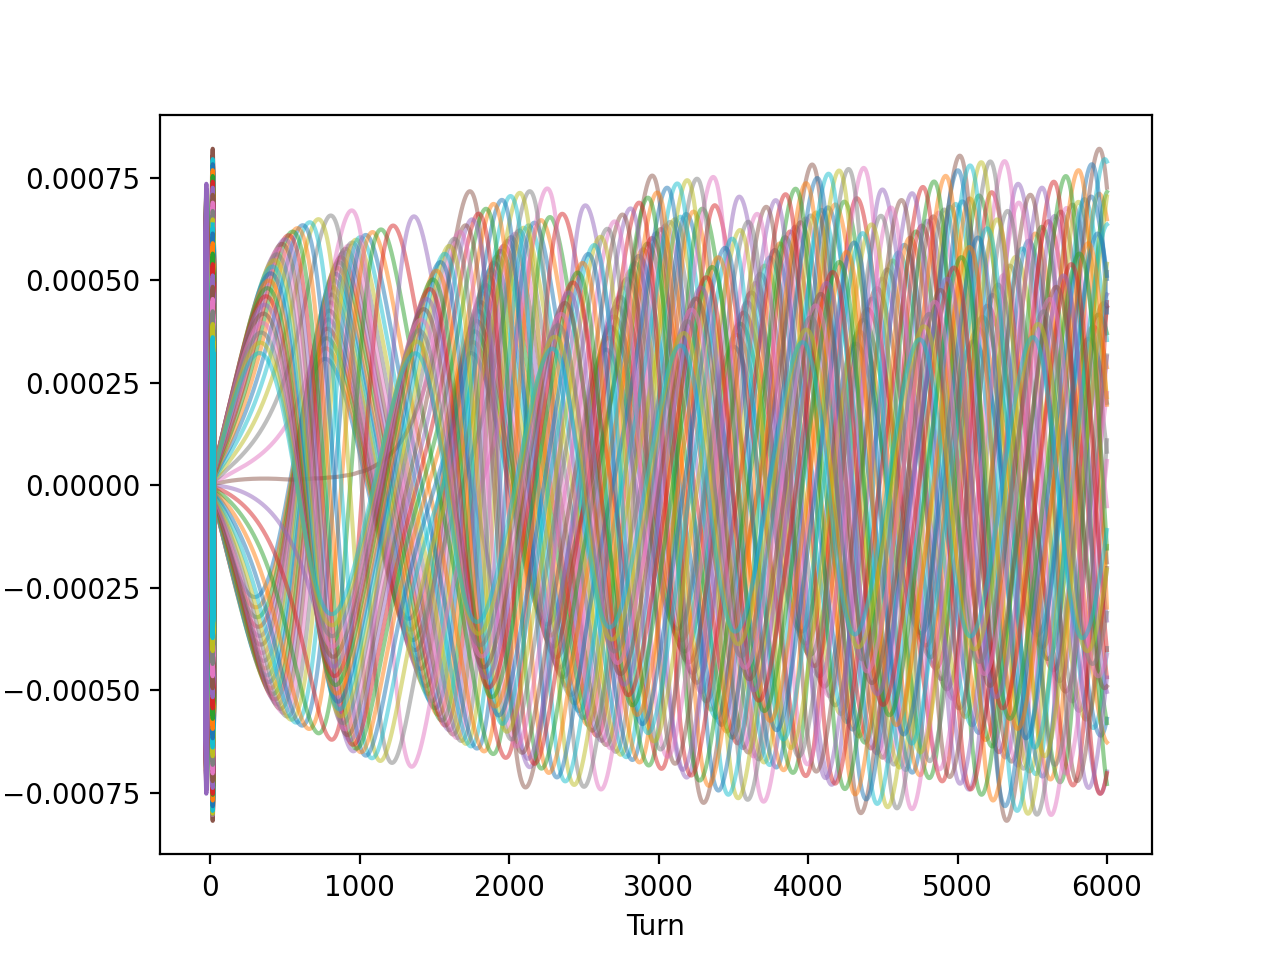

In [44]:
plt.figure(2)
plt.plot(monitor.delta.T, alpha=0.5)
plt.xlabel('Turn')
plt.ylabel('delta')
plt.show()

In [45]:
np.mean(monitor.x, axis=1)

array([-0.01887147, -0.01886922, -0.01886602, -0.01886185, -0.01885685,
       -0.01885141, -0.01884628, -0.01884245, -0.01884089, -0.01884213,
       -0.01884589, -0.01885113, -0.01885655, -0.0188611 , -0.01886427,
       -0.01886593, -0.01886619, -0.01886517, -0.01886295, -0.0188594 ,
       -0.01885413, -0.01884642, -0.0188356 , -0.01882254, -0.01882764,
       -0.01892649, -0.01888982, -0.01889599, -0.01890283, -0.01891459,
       -0.01892572, -0.01892548, -0.01891396, -0.01889994, -0.01888907,
       -0.01888284, -0.0188813 , -0.01888419, -0.0188908 , -0.01889931,
       -0.01890669, -0.01891008, -0.0189086 , -0.01890355, -0.01889703,
       -0.01889077, -0.01888563, -0.01888188, -0.01887941, -0.01887799])

<IPython.core.display.Javascript object>


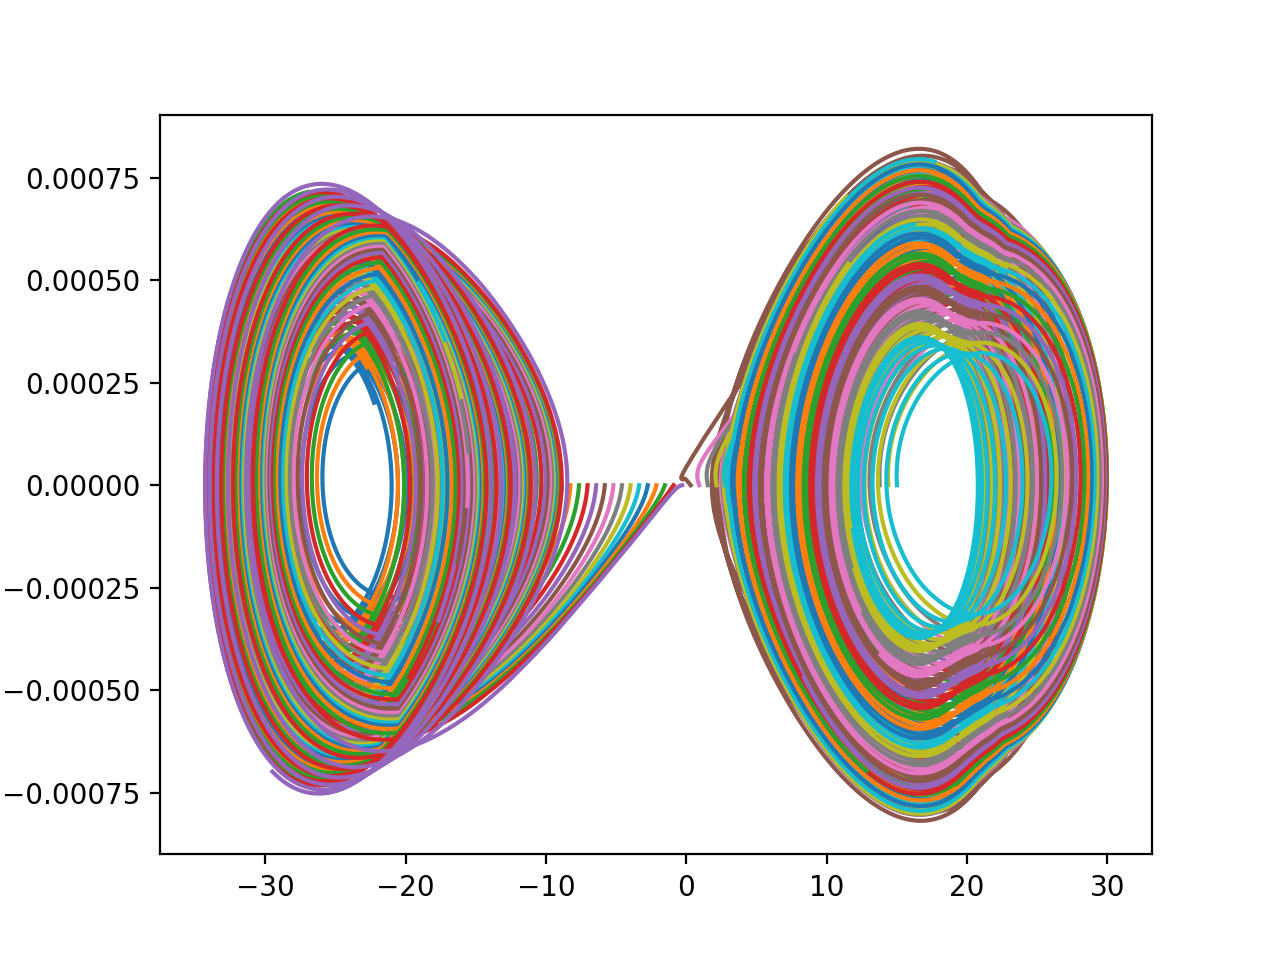

In [47]:
plt.figure(100)
plt.plot(monitor.zeta.T, monitor.delta.T)

In [18]:
line.enable_time_dependent_vars = False

In [19]:
tw = line.twiss(method='6d')

-------